# Unsupervised Bayesian model

## How to use the notebook

The following cells:
- specify objective, variables, and dependencies,
- set up the outlier detection models,
- read dataset,
- present results from the models.

To just see how it works for a toy example, simply run the whole notebook as is.

For your own project, adjust the details about objectives, variables, dataset etc. and then execute all cells in order.
The board "bayesian.board" will help you with detailed instructions.

# General Imports and Setup

In [1]:
import os
import shutil
from distutils.dir_util import copy_tree

import numpy as np
import pandas as pd
import halerium.core as hal

import matplotlib.pyplot as plt

from joblib import dump, load


By using this Application, You are agreeing to be bound by the terms and conditions of the Halerium End-User License Agreement that can be downloaded here: https://erium.de/halerium-eula.txt


# Project

In [2]:
experiment_name = {{cookiecutter.project_name}}  # please provide a name for the outlier detection experiment

# Dataset

In [3]:
time_series = False # Specify if the data is time series
path = '{{cookiecutter.data_path}}' # Specify the path of the data

if path == 'default example':
    path = 'https://raw.githubusercontent.com/erium/halerium-example-data/main/outlier_detection/height_weight.csv'

if time_series:
    df = pd.read_csv(path, parse_dates=['date'], index_col = 'date')
else:
    df = pd.read_csv(path)

num_col = len(df.columns)

out_path = './../out'
isExist = os.path.exists(out_path)
if isExist:
  for root, dirs, files in os.walk(out_path):
      for f in files:
          os.unlink(os.path.join(root, f))
      for d in dirs:
          shutil.rmtree(os.path.join(root, d))
else:
  os.makedirs(out_path)

Visualising the dataset

In [4]:
df

,Height,Weight,Age,Sex,Race
0,67.8,166,210,0,1
1,63.0,93,144,1,0
2,50.1,54,119,0,0
3,55.7,69,130,1,0
4,63.2,115,157,0,0
...,...,...,...,...,...
193,62.8,94,183,0,0
194,64.5,130,189,1,1
195,66.1,135,189,1,0
196,66.1,119,174,1,0


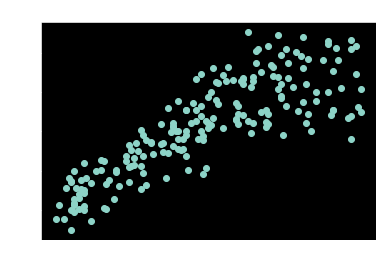

In [5]:
plt.title("Plot of age against height")
plt.scatter(df["Age"], df["Height"])
plt.xlabel('Age')
plt.ylabel('Height')
plt.show()

# Defining the variables

In [6]:
graph = hal.Graph("graph")
with graph:
    # Defining a variable you would like to model (usually a feature in the data)
    hal.Variable("age",
                 distribution="LogNormalDistribution") # we pick the log-normal distribution since age is a positive number
    hal.StaticVariable("age_mean_log", # Define the mean log of the variable
                       distribution="NormalDistribution", # the mean log can be negative or positive
                       mean=0, variance=4) # Define the known/assumed statistical properties
    hal.StaticVariable("age_variance_log",
                       distribution="LogNormalDistribution", # a variance has to be positive
                       mean_log=0, variance_log=1,)
    
    # Set the attributes of the variable
    age.mean_log = age_mean_log
    age.variance_log = age_variance_log

    hal.Variable("height")
    hal.StaticVariable("height_curve_parameters", shape=(2,), mean=0, variance=1)
    # You may set the mathematical formulation of properties based on other properties
    height.mean = height_curve_parameters[0] * hal.math.sqrt(age) / 2 + height_curve_parameters[1]
    hal.StaticVariable("height_variance",
                       distribution="LogNormalDistribution", # a variance has to be positive
                       mean_log=-3, variance_log=1,)
    # Set the attributes of the variable
    height.variance = height_variance

## Training the model

In [7]:
posterior_model = hal.get_posterior_model(graph, data={graph.age: df["Age"], graph.height: df["Height"]})
posterior_model.solve()
post_samples = posterior_model.get_samples(graph.height_curve_parameters, n_samples=1000)

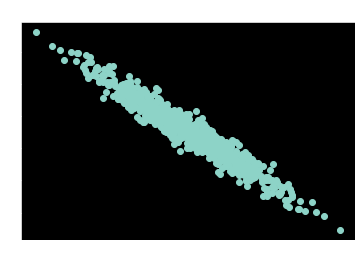

In [8]:
plt.title("Plot of model parameters")
plt.scatter(np.array(post_samples)[:, 0], np.array(post_samples)[:, 1])
plt.show()

In [9]:
trained_graph = hal.Trainer(graph, data={graph.age: df["Age"], graph.height: df["Height"]})()

In [10]:
# Predicted statistical features of parameters
hal.Predictor(trained_graph, measure=('mean', 'standard_deviation'))([trained_graph.height_curve_parameters])

[(array([9.10458879, 3.53739378]), array([0.17927393, 0.90917848]))]

In [11]:
# Predicted statistical features of height variance
hal.Predictor(trained_graph, measure=('mean', 'standard_deviation'))([trained_graph.height_variance])

[(11.180455346480837, 1.1126706471100787)]

In [12]:
# Samples from the trained graph
samples = hal.get_generative_model(trained_graph).get_samples({"age": trained_graph.age,
                                                               "height": trained_graph.height},
                                                              n_samples=1000)

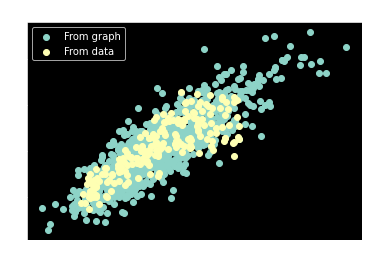

In [13]:
plt.title('Plot of points from original data and trained graph')
plt.scatter(np.reshape(samples["age"], -1), np.reshape(samples["height"], -1), label='From graph')
plt.scatter(df["Age"], df["Height"], label='From data')
plt.legend()
plt.show()

In [14]:
age_input = np.linspace(100, 250, 100)
height_pred = hal.Predictor(trained_graph, measure='mean', data={trained_graph.age: age_input})(trained_graph.height)

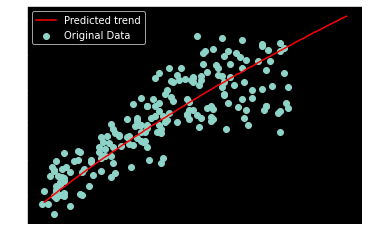

In [15]:
plt.plot(age_input, height_pred, color='r', label='Predicted trend')
plt.scatter(df["Age"], df["Height"], label='Original Data')
plt.legend()
plt.show()

## Detecting the outliers

In [16]:
# Detect outliers in the data
out_detector = hal.objectives.OutlierDetector(trained_graph, data={graph.age: df["Age"], graph.height: df["Height"]})

In [17]:
# Univariate outliers and outlier for entire data point
out_detector()

{'graph': array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, Fals

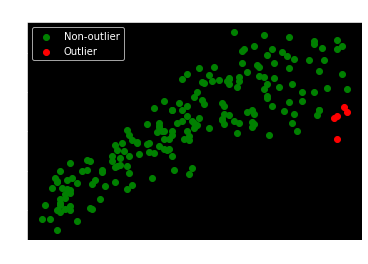

In [18]:
outlier_flags = out_detector()['graph'] # outliers in context of whole graph
plt.title('Plot of outlier points')
plt.scatter(df["Age"][~outlier_flags], df["Height"][~outlier_flags], color="green", label='Non-outlier')
plt.scatter(df["Age"][outlier_flags], df["Height"][outlier_flags], color="red", label='Outlier')
plt.legend()
plt.show()

## Outlier prediction and export

In [24]:
df_final = df.copy()
df_final['outlier'] = 0
outliers = []
for i, outlier in enumerate(outlier_flags):
    if outlier:
        outliers.append(i)
df_final.loc[df_final.index[outliers], 'outlier'] = 1
df_final

,Height,Weight,Age,Sex,Race,outlier
0,67.8,166,210,0,1,0
1,63.0,93,144,1,0,0
2,50.1,54,119,0,0,0
3,55.7,69,130,1,0,0
4,63.2,115,157,0,0,0
...,...,...,...,...,...,...
193,62.8,94,183,0,0,0
194,64.5,130,189,1,1,0
195,66.1,135,189,1,0,0
196,66.1,119,174,1,0,0


In [25]:
# Export as CSV
df_final.to_csv('./../out/labeled_data')

In [20]:
# Exports the trained graph
graph.dump_file('./../out/graph.json')
trained_graph.dump_file("./../out/trained_graph.json")
dump([df, time_series], './../out/unsupervised_bayesian.joblib')

['./../out/unsupervised_bayesian.joblib']

In [21]:
# Show the graph
hal.show(trained_graph)

halerium graph 'graph'